# Conversion of light scatter measured by flow cytometry to cell size distribution (carbon quotas)

Cell size distributions were inferred from flow-cytometry based forward-angle light scatter measurements (FALS).
FALS signals normalized by calibration beads were converted to a proxy of mass using the relationships $M = \text{FALS}^{1/1.74}$ [Burbage et al. 2007](https://doi.org/10.1111/j.1529-8817.2007.00315.x) and then converted to carbon quotas assuming an average carbon quotas of 53 fg C cell$^{-1}$ [Zinser et al. 2009]( https://doi.org/10.1371/journal.pone.0005135).

Note: you need to have downloaded the FCS files to run this script.

In [1]:
# set the path to the FCS folder
setwd("PASTE/here/the/path/to/the/folder")

### 1. Load libraries and functions

In [2]:
library(flowCore)
library(tidyverse)

# read FCS files
read_fcs <- function(fcs_file, transformation=TRUE){

  df.fcs <- dplyr::as_tibble(flowCore::exprs(flowCore::read.FCS(fcs_file, transformation=transformation, emptyValue=F)))
  fcs <- df.fcs %>%
          add_column(file = paste(fcs_file), pop = "unknown")
  return(fcs)
}

# Gating Prochlorococcus
manual_classify <- function(fcs, params, popname){

  poly <- params # Get gating polygon definition
  para <- colnames(poly)  # channels

  df <- fcs[, para]
  colnames(poly) <- colnames(df) <- c("x","y") # to stop stupid Warnings from splancs::inout()
  id <- splancs::inout(df,poly=poly, bound=TRUE, quiet=TRUE) # indices particles based on Gate
  fcs <- fcs %>%
           mutate(pop = replace(pop, id & pop == "unknown", popname))  # update particle label

  return(fcs)
}

classify_fcs <- function(fcs, gates.log) {
  for (popname in names(gates.log)) {
    params <- gates.log[[popname]]
    fcs <- manual_classify(fcs, params, popname)
   }
  return(fcs)
}

plot_cytogram <- function (fcs, para.x = "scatter", para.y = "red", ...){
  
  group.colors <- c(unknown="grey", beads="red3",prochloro=viridis::viridis(4)[1])
  fcs$pop <- factor(fcs$pop, levels = names(group.colors))
  caption <- group.colors[unique(fcs$pop)]

  par(pty = "s")
  plot(fcs[, c(para.x, para.y)], pch = 16, cex = 0.3, col = group.colors[fcs$pop],log="xy",  ...)
  legend("topleft", legend = names(caption), col = caption,
      pch = 16, pt.cex = 0.6, bty = "n")
  abline(v=1, h=1, col="grey", lty=2)
}

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks flowCore::filter(), stats::filter()
✖ dplyr::lag()    masks stats::lag()



### 2. Load the data

In [3]:
# Get list of FCS files
file_list <- list.files(".", pattern = "ZIJDEC20")

# Get metadata and add column for analytical volume (mL), 
# where samples were diluted 100X and 0.02 mL was analyzed by the flow cytometer
meta <- read_csv("metadata.csv") %>%
        add_column(volume = 0.02/100)


── Column specification ────────────────────────────────────────────────────────
cols(
  Sample = col_double(),
  Description = col_character(),
  Day = col_double(),
  Time = col_double(),
  timepoint = col_double(),
  file = col_character(),
  events = col_double(),
  sec = col_double(),
  REDmean = col_double(),
  REDcv = col_double(),
  FALSmean = col_double(),
  FALScv = col_double(),
  BLUEmean = col_double(),
  BLUEcv = col_double()
)




### 3. Initalization

In [4]:
#################################
###  A. Renaming column names ###
#################################

# load a random file
this_file <- file_list[3]

# create a dataframe WITH log-amplified data
fcs <- read_fcs(this_file, transformation = TRUE) 

# Find the index of each variable of interest: FSC, 692, 580 and 530 respectively
print(names(fcs))
id <- c(6,8,1,3) 
names(fcs)[id]

# replace original names of FSC, 692, 580 and 530 respectively
names_pmt <- names(fcs)[id] 


###########################################################
### B. Define breaks for the Particle Size Distribution ###
###########################################################
# create log2 spaced size classes
m <- 180
min <- 0.03 # pgC (min.quotas 2.5 fgC)
delta <- 1/32# define the width of each bin
breaks <- round(min*2^(((1:m)+1)*delta),6) # log 2 spaced binning

print(range(breaks))

Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


 [1] "Orange FL"   "IPHA Blue"   "Blue Fls"    "red-Red Fls" "90 SS"      
 [6] "HFLS"        "VFLS"        "Red Fls"     "TI"          "file"       
[11] "pop"        


[1] "HFLS"      "Red Fls"   "Orange FL" "Blue Fls"

[1] 0.031328 1.512942


### 4. Counting the number of Prochlorococcus cells in each size classes

In [5]:
system("mkdir gating")

distribution <- tibble()

for (this_file in file_list[-1]){

    #####################
    ### Read FCS data ###
    #####################
    # this_file <- file_list[2]
    print(paste(this_file))

    # Skip file ZIJDEC20.051 (used as blank, no cells in it)
    id <- grep(basename(this_file), meta$file, ignore.case=T)
    if(length(id) == 0) next
    
    # create a dataframe WITH log-amplified data)
    fcs <- read_fcs(this_file, transformation = TRUE) 
    
    # rename header
    names(fcs)[match(names_pmt, names(fcs))] <- c("scatter", "red", "orange", "green")

    ##############
    ### Gating ###
    ##############
    # Load gating scheme (gates.log, polygon coordinates for Beads and Prochlorococcus)
    # see function FCSplankton::set.gating.parameters for more details (https://github.com/fribalet/FCSplankton)
    load("Gating.RData") 

    # Assign "beads" label to particles
    fcs <- classify_fcs(fcs, gates.log[][1])

    # Normalization
    beads <- fcs[which(fcs$pop == "beads"),]
    fcs$norm.scatter <- fcs$scatter / median(beads$scatter)
    fcs$norm.orange <- fcs$orange / median(beads$orange)
    fcs$norm.red <- fcs$red / median(beads$red)
    fcs$norm.green <- fcs$green / median(beads$green)
    
    # Apply gating scheme
    fcs <- classify_fcs(fcs, gates.log)
    
    # Save plot
    png(paste0("gating/",this_file, ".png"),width=12, height=12, unit="in", res=200)
    par(pty="s", cex=1.2)
    plot_cytogram(fcs, "norm.scatter","norm.red", ylab="red\n (normalized to beads)", xlab="scatter\n (normalized to beads)")
    dev.off()
 
    ####################################################
    ### Conversion scatter values to a proxy of mass ###
    ####################################################
    # M = FALS ^ (1/1.74) (Burbage and Binder 2007)
    fcs$quotas <- fcs$norm.scatter^(1/1.74) # arbitruary unit
      
    ######################################################
    ### COUNT NUMBER OF PARTICLES IN EACH SIZE CLASSES ###
    ######################################################
    psd <- fcs %>% filter(pop == "prochloro") %>%
            select(quotas) %>%
            group_by(breaks=cut(quotas, breaks), .drop=F) %>%
            count(breaks) %>%
            pivot_wider(names_from = breaks, values_from = n) 

    psd <- psd %>% add_column(time= meta$timepoint[id], .before=1) %>%
                  add_column(volume= meta$volume[id], .after=1)

    distribution <- dplyr::bind_rows(distribution, psd)

}

# Sort by date
distribution <- distribution[order(distribution$time),]

[1] "ZIJDEC20.001"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.002"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.003"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.004"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.005"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.006"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.007"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.008"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.009"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.010"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.011"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.012"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.013"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.014"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.015"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.016"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.017"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.018"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.019"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.020"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.021"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.022"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.023"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.024"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.025"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.026"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.027"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.028"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.029"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.030"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.031"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.032"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.033"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.034"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.035"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.036"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.037"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.038"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.039"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.040"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.041"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.042"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.043"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.044"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.045"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.046"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.047"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.048"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.049"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.050"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.051"
[1] "ZIJDEC20.052"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.053"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.054"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.055"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.056"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.057"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.058"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.059"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.060"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.061"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.062"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.063"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.064"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.065"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.066"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.067"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.068"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.069"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.070"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.071"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.072"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.073"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.074"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.075"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.076"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.077"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.078"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.079"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.080"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.081"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.082"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.083"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.084"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.085"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.086"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.087"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.088"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.089"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.090"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.091"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.092"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.093"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.094"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.095"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.096"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.097"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.098"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.099"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.100"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.101"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.102"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


[1] "ZIJDEC20.103"


Warning message:
“No '$PnE' keyword available for the following channels: 9
Using '0,0' as default.”


### 5. Convert mass (arbitruary unit) to carbon quotas
Here we assume that the mean carbon quotas during the experiment is 53 fg cell-1 (Zinser et al. 2009)

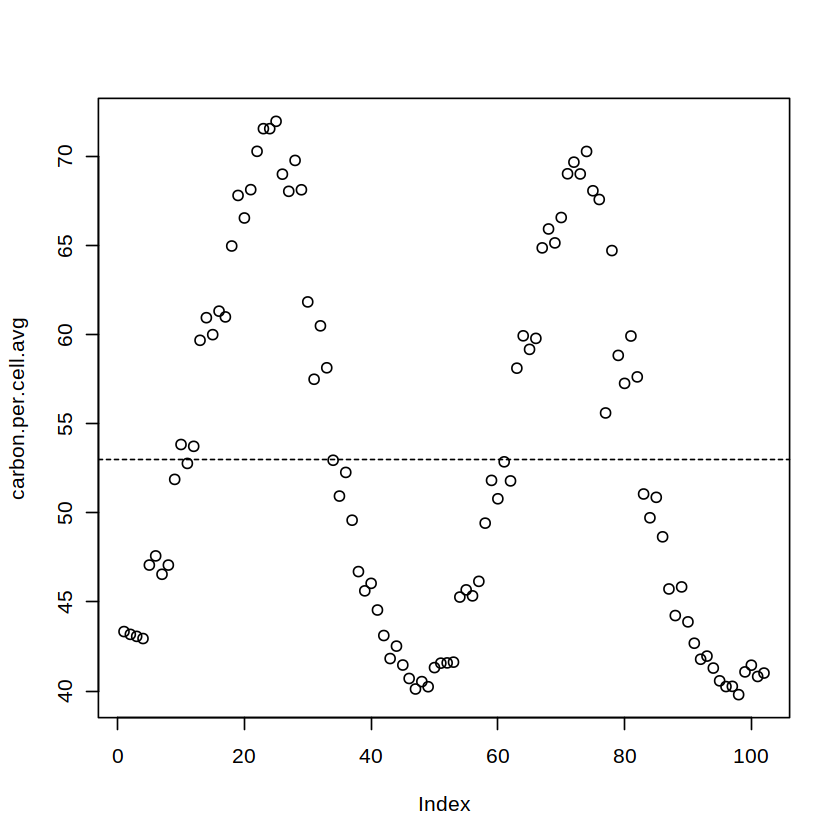

In [6]:
# indices of columns size classes
clmn <- grep("]", names(distribution))

# calculate cell abundance in each size classes
clmn <- grep("]", names(distribution))
distribution[,clmn] <- distribution[,clmn] / distribution[["volume"]]

# calculate mean mass over the entire experiment
b <- strsplit(sub("\\]","",sub("\\(","",colnames(distribution)[clmn])),",")
mass <- unlist(list(lapply(b, function(x) sqrt(mean(as.numeric(x))*max(as.numeric(x))))))
q <- t(diag(mass) %*%  t(as.matrix(distribution[,clmn])))
mass.per.cell.avg <- rowSums(q)/rowSums(distribution[,clmn])
                        
# convert Mass to Carbon quotas assuming mean Quotas = 53 fg cell-1 
REFERENCE_QUOTA <- 53                           
f <- REFERENCE_QUOTA / mean(mass.per.cell.avg)                         
quotas <-  mass * f
colnames(distribution)[clmn] <- as.character(round(quotas,3))

# Plot mean Carbon quotas
carbon.per.cell.avg <- mass.per.cell.avg  * f                              
plot(carbon.per.cell.avg); abline(h=REFERENCE_QUOTA, lty=2)

### 6. Save data

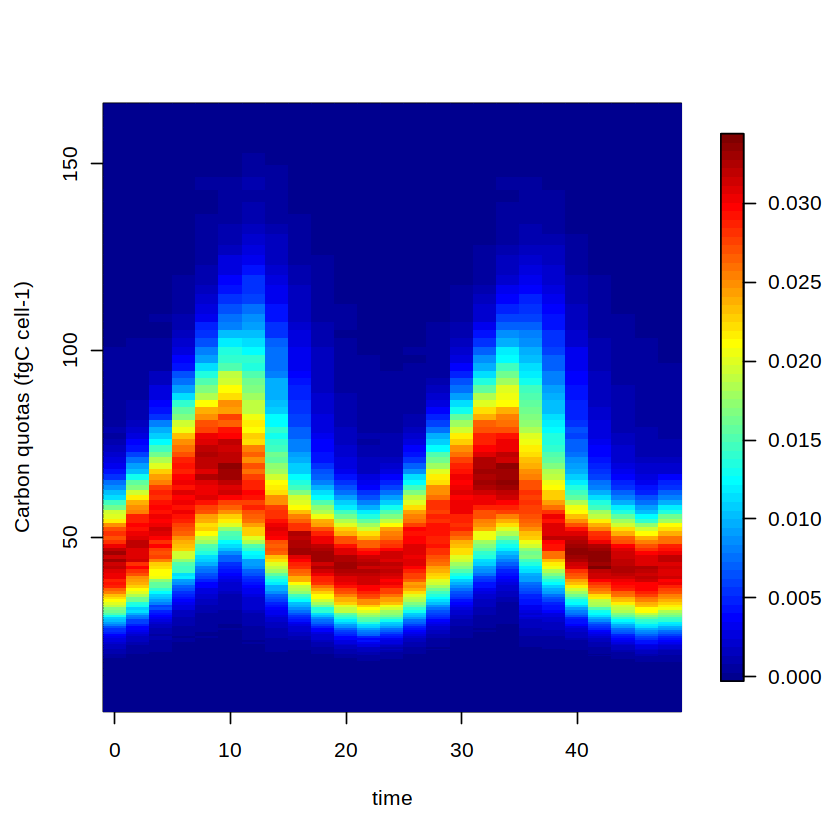

In [10]:
# Calculate mean of replicates
PSD   <- distribution   %>%
              dplyr::group_by(time) %>%
              dplyr::summarise_all(mean) 

# plot PSD
Ndist <- data.matrix(PSD[,clmn])          
Vdist <- Ndist / rowSums(Ndist, na.rm=T)  
fields::image.plot(x=PSD$time,y=quotas,z=Vdist, xlab="time", ylab="Carbon quotas (fgC cell-1)")

# to be compatible with "regrid_csv_to_nc.py"
colnames(PSD)[1] <- "NaN" # replace first column name by NaN
PSD[,1] <- c(seq(8,22,2), seq(0,22,2), seq(0,8,2)) # hours of the day
id <- as.numeric(which(colSums(PSD) == 0)) # remove empty size classes

write_csv(PSD[,-c(2, id)], "zinser_psd.csv")